# TensorFlow Installation and Setup

First, let's install TensorFlow and required dependencies.

In [45]:
# Install TensorFlow and dependencies
%pip install --quiet tensorflow numpy pandas matplotlib seaborn
print("Package installation completed. Please restart the kernel if this is the first installation.")

Note: you may need to restart the kernel to use updated packages.
Package installation completed. Please restart the kernel if this is the first installation.


In [46]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display

# TensorFlow setup
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow logging
import tensorflow as tf
print("Setting up TensorFlow...")
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"GPU(s) detected and configured: {len(physical_devices)}")
    except:
        print("Error configuring GPU. Using CPU.")
else:
    print("No GPU detected. Using CPU.")

# Configure visualization settings
sns.set(style='darkgrid', font_scale=1.2)
plt.rcParams.update({
    'figure.figsize': [12, 6],
    'figure.dpi': 100,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'lines.linewidth': 2,
    'lines.markersize': 8,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd()))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_processor import DataProcessor
from src.model import LSTMModel
from src.utils.visualization import Visualizer, Evaluator

# Print environment information
print(f"\nEnvironment Information:")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")

Setting up TensorFlow...
No GPU detected. Using CPU.

Environment Information:
TensorFlow version: 2.20.0
Keras version: 3.11.3
Python version: 3.12.1 (main, Jul 10 2025, 11:57:50) [GCC 13.3.0]
NumPy version: 2.3.3
Pandas version: 2.3.3
Seaborn version: 0.13.2


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


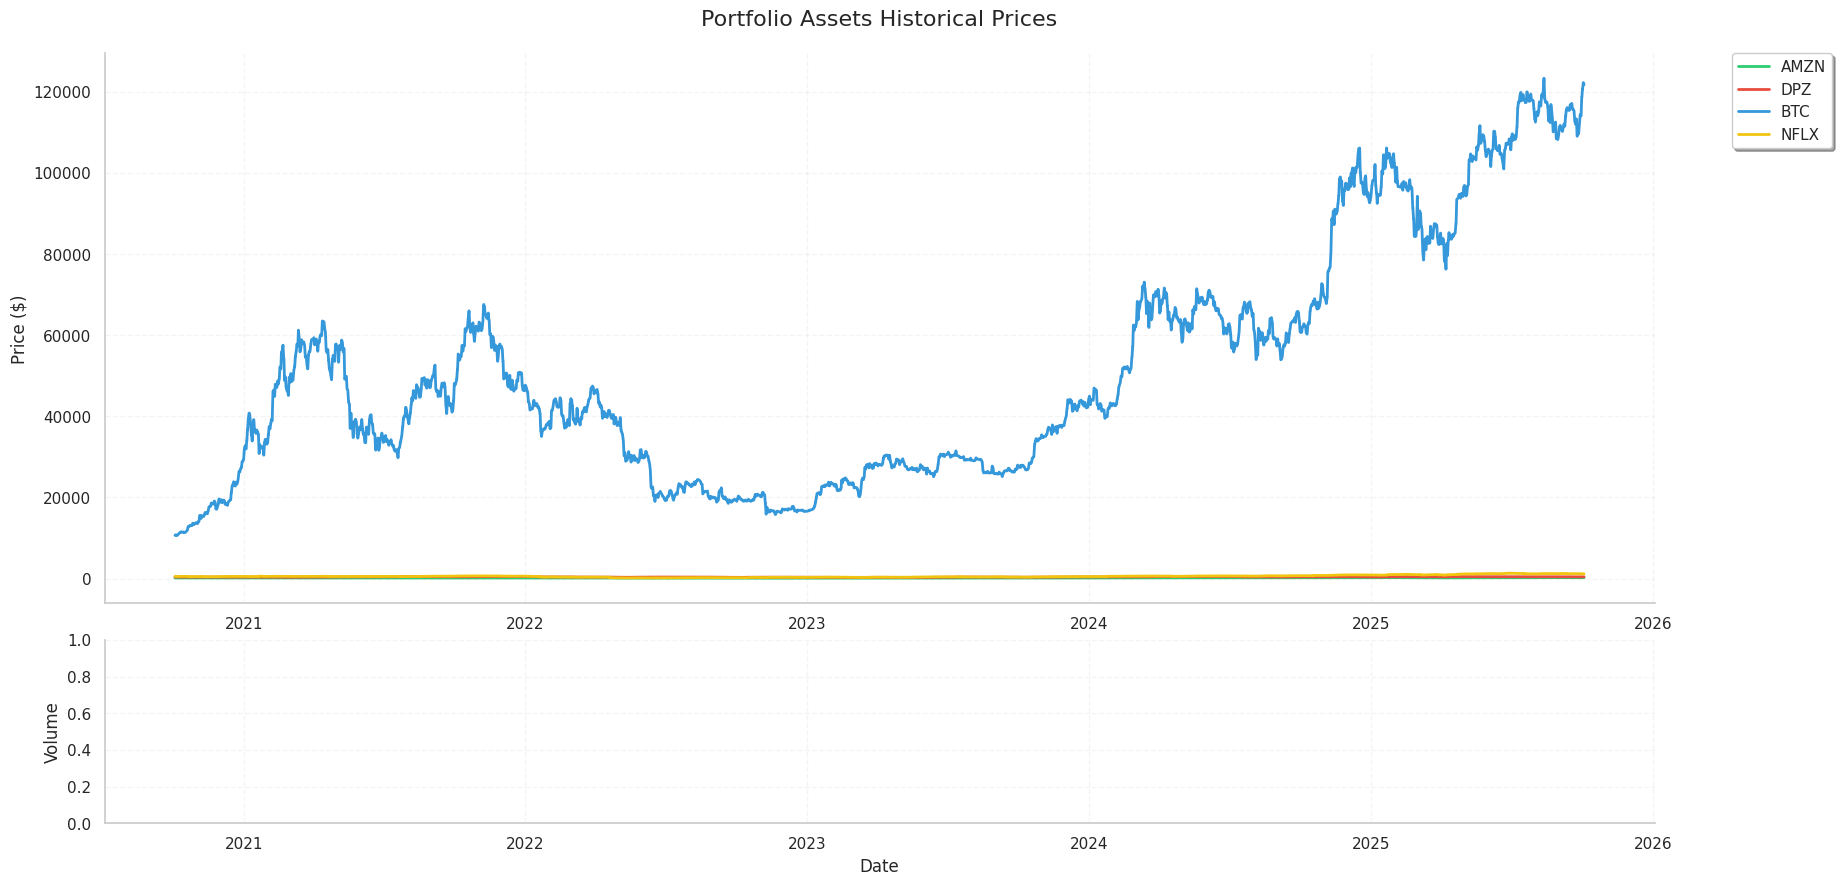

<Figure size 1200x800 with 0 Axes>

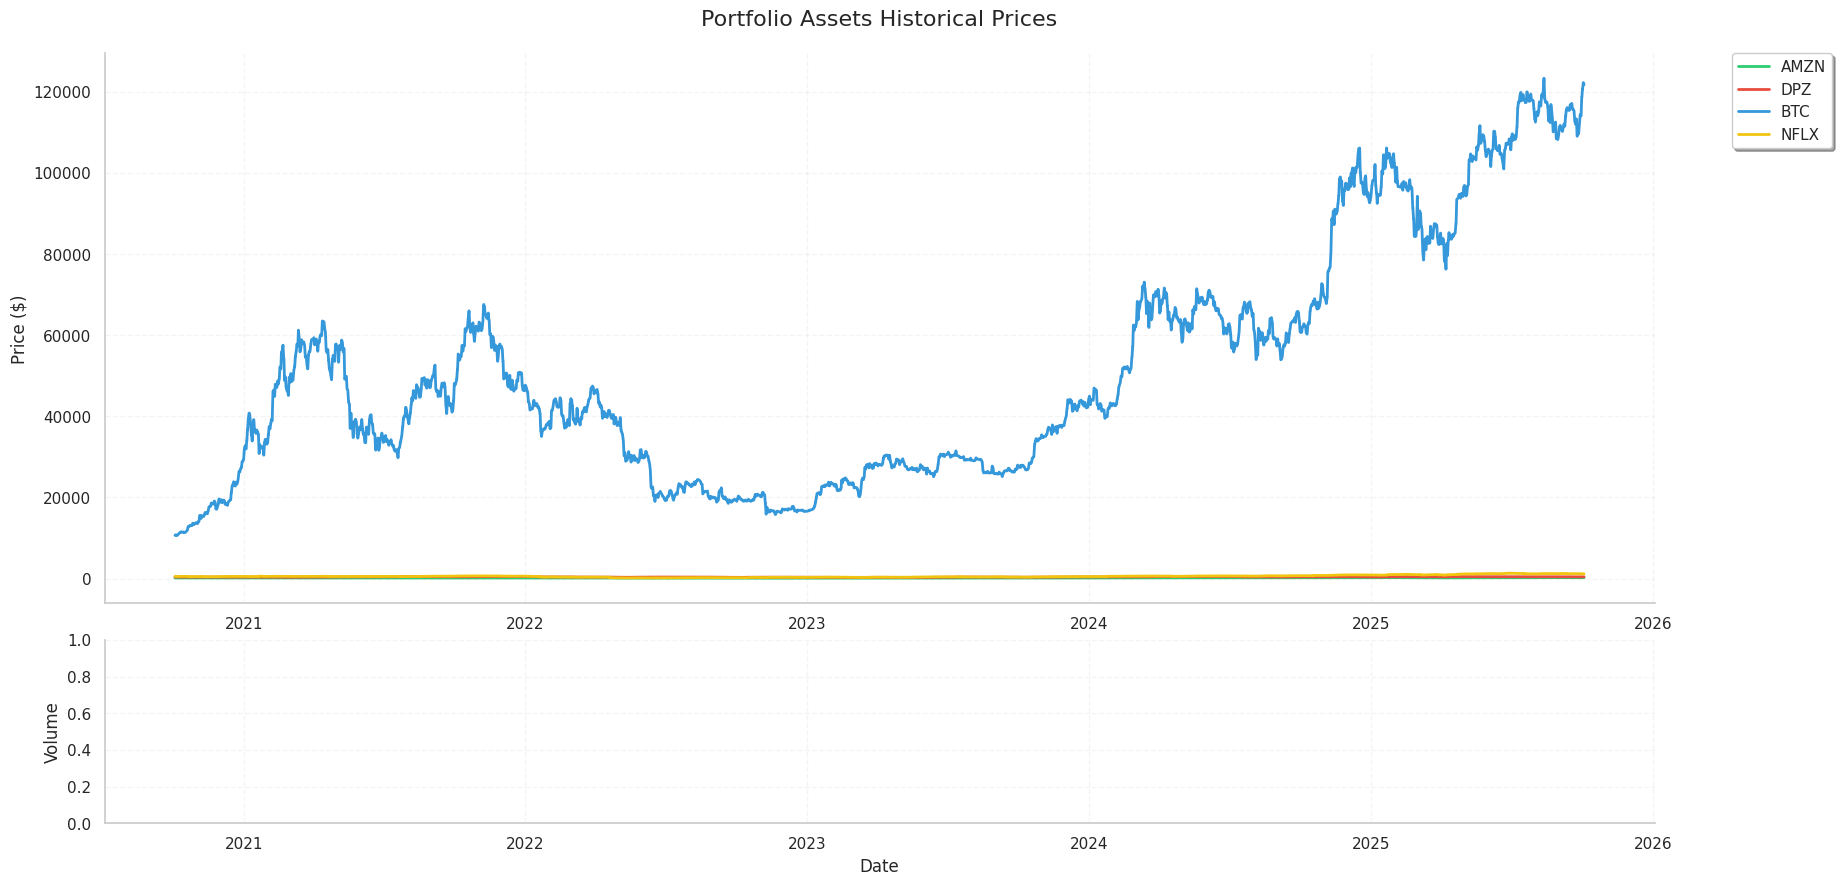

Plot saved to 'latest_plot.png'


<Figure size 1200x800 with 0 Axes>

In [47]:
# Configuration
SEQUENCE_LENGTH = 60
TEST_SPLIT = 0.2
EPOCHS = 100
BATCH_SIZE = 32
LSTM_UNITS = [128, 64]
DROPOUT_RATE = 0.2
TARGET_ASSET = 'AMZN'

# Initialize data processor
data_processor = DataProcessor(sequence_length=SEQUENCE_LENGTH)

# Load and preprocess data
df = data_processor.load_data('data/portfolio_data.csv')

# Define features
feature_columns = ['AMZN', 'DPZ', 'BTC', 'NFLX']

# Plot historical data
print("\nVisualizing historical data for portfolio assets...")
fig = plt.figure(figsize=(12, 6))
Visualizer.plot_stock_history(df[feature_columns], title="Portfolio Assets Historical Prices")
display(plt.gcf())  # Display the current figure
plt.close()  # Close the figure to free memory

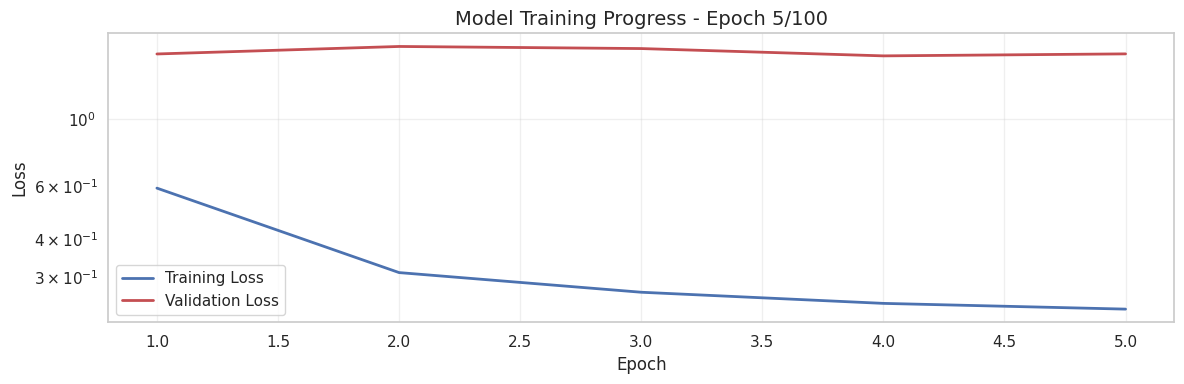

76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 384ms/step - loss: 0.2351 - val_loss: 1.6403 - learning_rate: 0.0010
Epoch 6/100


In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np

# Verify TensorFlow installation
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

try:
    # Prepare data for training
    print("Preparing training data...")
    X_train, X_test, y_train, y_test = data_processor.prepare_data(
        df, feature_columns=feature_columns, test_split=TEST_SPLIT
    )

    # Print shapes and data statistics for verification
    print("\nData shapes and statistics:")
    print(f"X_train shape: {X_train.shape} (Range: {X_train.min():.3f} to {X_train.max():.3f})")
    print(f"X_test shape: {X_test.shape} (Range: {X_test.min():.3f} to {X_test.max():.3f})")
    print(f"y_train shape: {y_train.shape} (Range: {y_train.min():.3f} to {y_train.max():.3f})")
    print(f"y_test shape: {y_test.shape} (Range: {y_test.min():.3f} to {y_test.max():.3f})")

    # Verify data integrity
    if np.isnan(X_train).any() or np.isnan(y_train).any():
        raise ValueError("Training data contains NaN values")
    if np.isnan(X_test).any() or np.isnan(y_test).any():
        raise ValueError("Test data contains NaN values")

    # Initialize and train model with correct number of features
    print("\nInitializing LSTM model...")
    model = LSTMModel(
        sequence_length=SEQUENCE_LENGTH,
        n_features=X_train.shape[2],
        units=LSTM_UNITS
    )

    # Create a custom callback for real-time plotting
    class RealTimePlotCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            super().__init__()
            self.train_losses = []
            self.val_losses = []
            
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            self.train_losses.append(logs.get('loss', 0))
            self.val_losses.append(logs.get('val_loss', 0))
            
            clear_output(wait=True)
            plt.figure(figsize=(12, 4))
            plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, 'b-', label='Training Loss')
            plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, 'r-', label='Validation Loss')
            plt.title(f'Model Training Progress - Epoch {epoch + 1}/{EPOCHS}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.yscale('log')  # Use log scale for better visualization
            display(plt.gcf())
            plt.close()

    # Set up callbacks with proper paths
    model_dir = os.path.join(project_root, 'models')
    os.makedirs(model_dir, exist_ok=True)
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=os.path.join(model_dir, 'best_model.h5'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        RealTimePlotCallback()
    ]

    # Train the model with error handling
    print("\nStarting model training...")
    try:
        history = model.model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=callbacks,
            verbose=1
        )
        print("\nTraining completed successfully!")
    except Exception as e:
        print(f"\nError during training: {str(e)}")
        raise

except Exception as e:
    print(f"\nError: {str(e)}")
    raise